## AFESamna with pure Samna

3
Start recording now...


[2024-10-15 12:00:52.026] [XyloAudio3] [warning] Dropping Spike event with neuronId 5


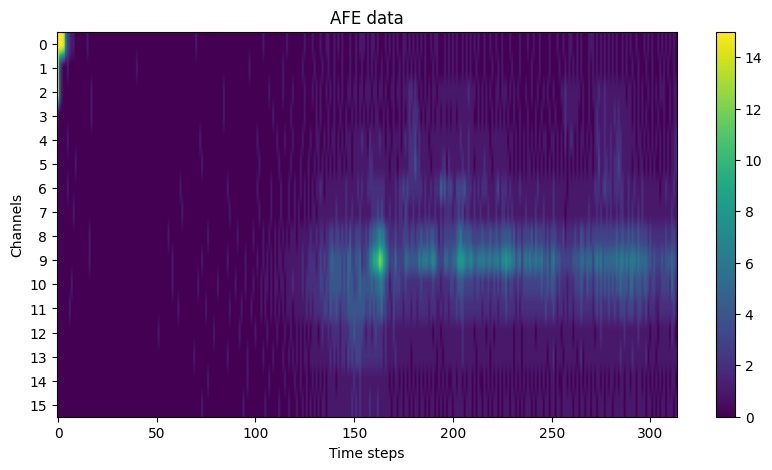

In [1]:
import samna
import time
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import simpleaudio as sa

# Open the device and connect the source and sink nodes so we can communicate with Xylo.
board = samna.device.open_device("XyloAudio3TestBoard")
xylo = board.get_model()
source = samna.graph.source_to(xylo.get_sink_node())
sink = samna.graph.sink_from(xylo.get_source_node())
stopwatch = board.get_stop_watch()


def plot_AFE_channels(afe_data,figure_size=None, xlim=None, ylim=None):
    """
    Args:
        afe_data (array): AFE data with dimensions channels x timesteps (16,timesteps)
        figure_size (tuple): x and y dimensions for figure size
        xlim (tuple): minimum and maximum x limit
        ylim (tuple): minimum and maximum y limit

    Returns:
        figure
    """
    # general figure parameters
    xtick_labels = np.arange(16)
    if figure_size:
        figure_size = figure_size
    else:
        figure_size = (10,5)
    cmap_color = 'jet_r'
    
    fig_label_size = 12
    
    # instantiate figure
    figure, axs = plt.subplots(1,figsize=figure_size,
                    facecolor='white')
    
    image = axs.imshow(afe_data,
                      # cmap=cmap_color,
                      aspect='auto')
    
    # add color bar
    axs.figure.colorbar(image)

    axs.set_yticks(xtick_labels)
    axs.set_yticklabels(xtick_labels, fontsize = fig_label_size-2)
    
    # set labels and titles
    axs.set_title("AFE data", fontsize = fig_label_size)
    axs.set_ylabel('Channels')
    axs.set_xlabel('Time steps')

    # set figure limits
    if xlim:
       axs.set_xlim(xlim) 
    if ylim:
        axs.set_ylim(ylim) 
    
    return figure

def get_wave_object(test_file): 
    sample_rate, data = wavfile.read(test_file)
    duration = int(len(data)/sample_rate) # in seconds
    n = data.ndim
    if data.dtype == np.int8:
        bytes_per_sample = 1
    elif data.dtype == np.int16:
        bytes_per_sample = 2
    elif data.dtype == np.int32:
        bytes_per_sample = 4     
    elif data.dtype == np.float32:
        bytes_per_sample = 4   
    else:
        raise ValueError("recorded audio should have 1 or 2 bytes per sample!")

    wave_obj = sa.WaveObject(
        audio_data= data,
        num_channels=data.ndim,
        bytes_per_sample=bytes_per_sample,
        sample_rate=sample_rate
    )  

    return duration,wave_obj   

test_file = "../../../docs/devices/xylo-a3/audio_sample/cry_sample_3sec.wav"
duration, wave_obj = get_wave_object(test_file)
print(duration)


# In Real-Time mode we have to specify a timestep duration.
# Default clock frequency was not changed, so we use that to calculate `tr_wrap`.
dt_s = 0.01 # 200 milliseconds
board_config = samna.xyloAudio3.XyloAudio3TestBoardDefaultConfig()
main_clock_frequency_hz = board_config.main_clock_frequency
tr_wrap = main_clock_frequency_hz * dt_s

def get_config(mode):
    xylo_config = samna.xyloAudio3.configuration.XyloConfiguration()
    xylo_config.operation_mode = mode
    xylo_config.debug.use_timestamps = False
    xylo_config.time_resolution_wrap = int(tr_wrap)

    # Choose PDM as input source.
    xylo_config.input_source = samna.xyloAudio3.InputSource.DigitalMicrophone
    # We need to set `clock_direction` to 1 (Xylo output), because there is no external clock.
    xylo_config.digital_frontend.pdm_preprocessing.clock_direction = 1
    xylo_config.digital_frontend.pdm_preprocessing.clock_edge = 0
    # Xylo clock frequency for PDM sampling can be influenced here.
    xylo_config.debug.sdm_clock_ratio = 23
    xylo_config.digital_frontend.filter_bank.dn_enable = True
    xylo_config.digital_frontend.filter_bank.use_global_iaf_threshold = True
    return xylo_config


def apply_config_blocking(config):
    xylo.apply_configuration(config)

    # Communication with the device is asynchronous, so we don't know when the configuration is finished.
    # Normally this is not a problem, because events are guaranteed to be sent in order.
    # But for this script we want to let Xylo run for a specific amount of time, so we need to synchronise somehow,
    # the easiest way is to read a register and wait for the response.
    source.write([samna.xyloAudio3.event.ReadRegisterValue(address=0)])
    ready = False
    while not ready:
        events = sink.get_events_blocking(timeout=1000)
        for ev in events:
            if isinstance(ev, samna.xyloAudio3.event.RegisterValue) and ev.address == 0:
                ready=True

read_auto = True 


auto_spikes = [list() for _ in range(16)]
if read_auto:
    # Configure Xylo in Recording mode and configure the timestep duration.
    xylo_config = get_config(samna.xyloAudio3.OperationMode.Recording)
    apply_config_blocking(xylo_config)
    # Once the configuration is set, the chip is already recording input.
    # But we want to define a clear time window in which we record, so we start the stopwatch to obtain event timesteps relative to this moment.
    # And also throw away any events we have received until now.
    stopwatch.start()
    sink.clear_events()

    print("Start recording now...")
    play_obj = wave_obj.play()
    play_obj.wait_done()

    events = sink.get_events()

    xylo.apply_configuration(samna.xyloAudio3.configuration.XyloConfiguration())

    assert isinstance(events[-1], samna.xyloAudio3.event.Spike)
    last_timestep = events[-1].timestep
    for aus in auto_spikes:
        aus.extend([0 for _ in range(last_timestep+1)])
    for ev in events:
        if isinstance(ev, samna.xyloAudio3.event.Spike) and ev.timestep <= last_timestep:
            auto_spikes[ev.neuron_id][ev.timestep] = min(15, auto_spikes[ev.neuron_id][ev.timestep] + 1)


len(events)

figure = plot_AFE_channels(auto_spikes)
plt.show()
 

In [2]:
len(auto_spikes[2])

314*16
# auto_spikes

5024

## AFESamna Rockpool

Start recording now...
10000


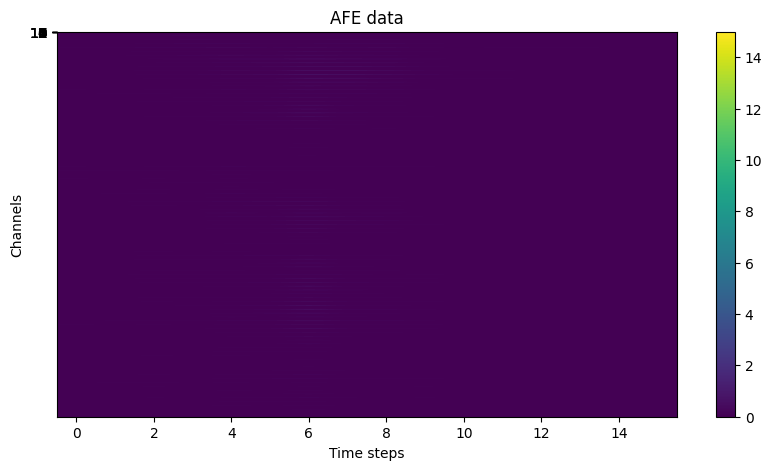

In [8]:
# Instantiate an AFE module, connected to a XyloAudio 3 HDK
from rockpool.devices.xylo.syns65302 import AFESamna
import rockpool.devices.xylo.syns65302.xa3_devkit_utils as xdu
afe_hdks = xdu.find_xylo_a3_boards()
afe = AFESamna(afe_hdks[0], dt = 0.01)

# Use the module to record some audio events

import numpy as np

print("Start recording now...")
play_obj = wave_obj.play()
play_obj.wait_done()

audio_events, _, dict_ = afe(np.zeros([0, 100, 0]), record=True)

print(len(audio_events))



figure = plot_AFE_channels(audio_events)
plt.show()
 


In [19]:
reverse(audio_events).shape

NameError: name 'reverse' is not defined

In [14]:
len(dict_['neuron_ids'])

2523

TypeError: Image data of dtype object cannot be converted to float

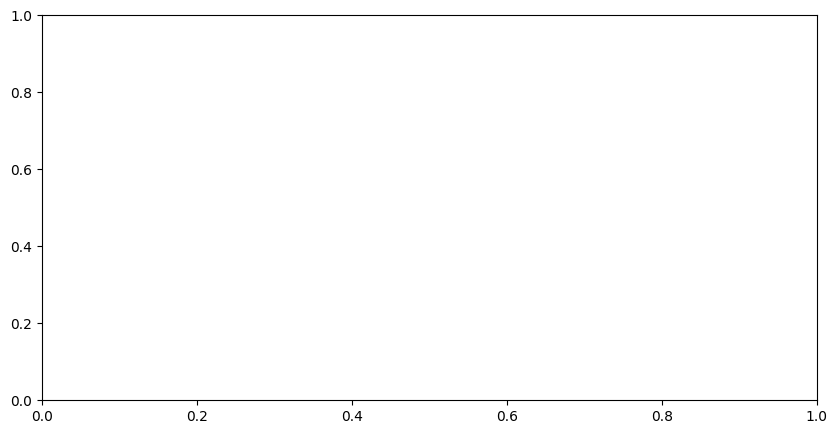

In [17]:
figure = plot_AFE_channels(dict_)
